# Vectorization for Speed

In [ ]:
import math
import time
import numpy as np
import torch

In [ ]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [ ]:
class Timer:
    #record multiple running times
    def __init__(self):
      self.times = []
      self.start()
    
    def start(self):
    #start the timer
      self.tik = time.time()
    
    def stop(self):
    #stop the timer and record time in a list
      self.times.append(time.time() - self.tik)
      return self.times[-1]
    
    def avg(self):
    #return the average time
      return sum(self.times) / len(self.times)
    
    def sum(self):
    #return the sum of time
      return sum(self.times)

    def cumsum(self):
    #return the accumulated time
      return np.array(self.times).cumsum().tolist()      

In [ ]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
  c[i] = a[i] + b[i]

f'{timer.stop(): .5f} sec'

' 0.11897 sec'

In [ ]:
timer.start()
d = a + b
f'{timer.stop(): .5f} sec'

' 0.00022 sec'

# Linear Regression Implementation from Scratch

In [ ]:
import random
import torch

In [ ]:
#Generating the Dataset

def synthetic_data(w, b, num_examples):
  """Generate y = Xw + b + noise"""
  X = torch.normal(0, 1, (num_examples, len(w))) 
  #making normal distribution (mean = 0, std = 16)
  #(num_examples, len(w)) = size -> a sequence of integers defining the shape of the ouput tensor
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))
  # -1 -> estimating from the dimention
  # 1 -> confirmed by user
  # y: 1차원의 타켓 값으로 재구성

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([0.1274, 0.2056]) 
label:  tensor([3.7605])


In [ ]:
# Reading the dataset

#data_iter: 임의로 선택된 feature과 tag들을 batch size 만큼 리턴
#왜 하나의 샘플을 사용하지 않고 여러 샘플을 사용? -> 최적화를 효율적으로!
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)

  #이 함수 이해 !!!
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

print(features)

tensor([[ 0.1274,  0.2056],
        [-0.1433, -0.1441],
        [ 0.9791, -0.0210],
        ...,
        [ 1.5446,  0.3801],
        [-0.0962,  1.3439],
        [ 0.1837, -0.4814]])


In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[ 0.6433,  0.9123],
        [-0.2261,  1.1952],
        [ 1.8414,  2.7158],
        [ 0.1126, -0.7801],
        [-1.3434,  0.7835],
        [ 0.7595, -0.2017],
        [ 1.4274,  0.7390],
        [ 0.3587,  0.2088],
        [-0.2521, -0.1899],
        [-0.4096, -1.0497]]) 
 tensor([[ 2.3926],
        [-0.3056],
        [-1.3597],
        [ 7.0856],
        [-1.1484],
        [ 6.4044],
        [ 4.5518],
        [ 4.1995],
        [ 4.3429],
        [ 6.9621]])


In [ ]:
#Initializing Model Parameters

w = torch.normal(0, 0.01, size = (2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
#requires_grad 속성을 True로 설정 = 그 tensor에서 이뤄진 모든 연산들을 추적

In [ ]:
#Defining the Model

def linreg(X, w, b):
  """The linear regression model"""
  return torch.matmul(X, w) + b

In [ ]:
#Defining the Loss Function

def squared_loss(y_hat, y):
  """Squred loss"""
  return (y_hat - y.reshape(y_hat.shape))**2 /2
  #y의 모양을 y_hat의 모양과 동일하게 바꿈

In [ ]:
#Defining the Optimization Algorithm

def sgd(params, lr, batch_size):
  """Minibatch stochastic gradient descent"""
  with torch.no_grad(): 
    #메모리 사용량을 줄이기 위한 것 -> autograd가 requires_grad = True인 Tensor들의 연산 기록을 추적하는 것을 멈출 수 있음
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [ ]:
#Training

lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

In [ ]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward() #역전파 Backward Propagation
    sgd([w, b], lr, batch_size)
  with torch.no_grad():
      train_l = loss(net(features, w, b), labels)
      print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}')

epoch 1, loss  0.033106
epoch 2, loss  0.000116
epoch 3, loss  0.000048
epoch 4, loss  0.000048
epoch 5, loss  0.000048
epoch 6, loss  0.000048
epoch 7, loss  0.000048
epoch 8, loss  0.000048
epoch 9, loss  0.000048
epoch 10, loss  0.000048


In [ ]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0006, -0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([9.7752e-05], grad_fn=<RsubBackward1>)


# Concise Implementation of Linear Regression

In [ ]:
#Generating the Dataset

from torch.utils import data

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
#Reading the Dataset

def load_array(data_arrays, batch_size, is_train=True):
  """Construct a PyTorch data iterator."""
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-1.1852, -1.0132],
         [-0.6415,  0.6876],
         [-2.0347, -0.1628],
         [-1.0914, -0.9063],
         [ 2.2670,  0.5832],
         [-2.0801, -0.7598],
         [ 0.5169,  1.1393],
         [ 0.6723, -1.4743],
         [-0.0640, -1.5647],
         [-0.9730, -0.2962]]), tensor([[ 5.2654],
         [ 0.5633],
         [ 0.6988],
         [ 5.0911],
         [ 6.7722],
         [ 2.6255],
         [ 1.3579],
         [10.5722],
         [ 9.3766],
         [ 3.2472]])]

In [ ]:
#Defining the Model

from torch import nn

net = nn.Sequential(nn.Linear(2,1))

In [ ]:
#Initailizing Model Parameters

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [ ]:
#Defining the Loss Function

loss = nn.MSELoss()

In [ ]:
#Defining the Optimization Algorithm

trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

In [ ]:
#Training

num_epochs = 3
for epoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features), labels)
  print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000305
epoch 2, loss 0.000109
epoch 3, loss 0.000109


In [ ]:
w = net[0].weight.data
print('error in estimating w: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b: ', true_b - b)

error in estimating w:  tensor([0.0007, 0.0003])
error in estimating b:  tensor([-0.0012])


# The Image Classification Dataset

In [ ]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
from numpy.core.numeric import True_

#Reading the Dataset

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = "../data", train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True
)

In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
def get_fashion_mnist_label(labels):
  """Return text labels for the Fashion-MNIST dataset."""
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels] 

In [ ]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 2):
  figsize = (num_cols * scale, num_rows*scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else:
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

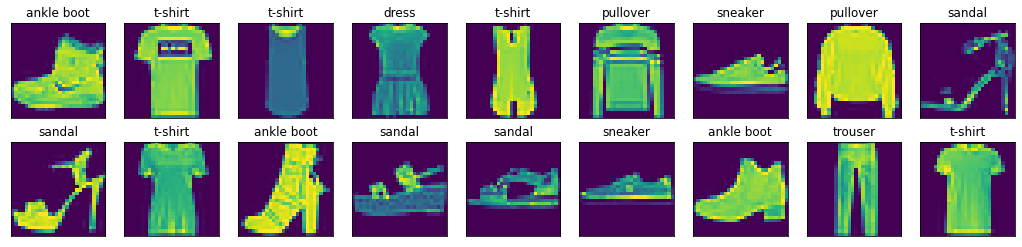

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size = 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_label(y));

In [ ]:
#Reading a Minibatch

batch_size = 256
def get_dataloader_workers():
  return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Putting All Things Together

def load_data_fashion_mnist(batch_size, resize=None):
  """Download the Fashion-MNIST dataset and then load it into memory."""
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
  root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
  root="../data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,
  num_workers=get_dataloader_workers()),
  data.DataLoader(mnist_test, batch_size, shuffle=False,
  num_workers=get_dataloader_workers()))


In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Implementation of Softmax Regression from Scratch

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Initializaing Model Parameters

num_inputs = 784 #28*28
num_outputs = 10 #10개의 카테고리
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True) #784*10
b = torch.zeros(num_outputs, requires_grad=True) #

In [ ]:
#Defining the Softmax Operation

#example of sum
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)
Y = X.sum(0, keepdim=True)
Z = X.sum(0, keepdim=False)
Y.shape, Z.shape


(torch.Size([1, 3]), torch.Size([3]))

In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True) #분모를 partition이라고 부르기도 하기 때문임
  return X_exp / partition

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1) #softmax 회귀는 전체 합이 1이기 때문임 

(tensor([[0.4707, 0.0683, 0.2371, 0.1302, 0.0937],
         [0.3732, 0.0603, 0.4482, 0.0836, 0.0347]]), tensor([1.0000, 1.0000]))

In [ ]:
#Defining the Model

def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [ ]:
#Defining the Loss Function

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)


tensor([2.3026, 0.6931])

In [ ]:
#Classification Accuracy

##이 함수 이해하기
def accuracy(y_hat, y):
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1) 
  cmp = y_hat.type(y.dtype) == y #y와 y_hat의 데이터 타입을 맞춰줌
  return float(cmp.type(y.dtype).sum())

In [ ]:
# accuracy(y_hat, y) / len(y)
len(y_hat.shape)
y_hat.shape

torch.Size([2, 3])

In [ ]:
def evaluate_accuracy(net, data_iter):
  """Compute the accuracy for a model on a dataset."""
  if isinstance(net, torch.nn.Module):
    net.eval() # 평가 모델로 변경
  metric = Accumulator(2) # No. of correct predictions, no. of predictions
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [ ]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.0816

In [ ]:
#Training

def train_epoch_ch3(net, train_iter, loss, updater):
  """The training loop defined in Chapter 3."""
  # Set the model to training mod
  if isinstance(net, torch.nn.Module):
    net.train()
  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  for X, y in train_iter:
  # Compute gradients and update parameters
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
  # Using PyTorch in-built optimizer & loss criterion
      updater.zero_grad()
      l.sum().backward()
      updater.step()
    else:
  # Using custom built optimizer & loss criterion
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  # Return training loss and training accuracy
  return metric[0] / metric[2], metric[1] / metric[2]


In [ ]:
class Animator:
  """For plotting data in animation."""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
    ylim=None, xscale='linear', yscale='linear',
    fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
    figsize=(3.5, 2.5)):
# Incrementally plot multiple lines
    if legend is None:
      legend = []
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # Use a lambda function to capture arguments
    self.config_axes = lambda: set_axes(
    self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
  def add(self, x, y):
  # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
      n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)


In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  animator = Animator(xlabel='epoch', xlim = [1, num_epochs], ylim=[0.3, 0.9],
                      legend = ['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr = 0.1

def updater(batch_size):
  return sgd([w, b], lr, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


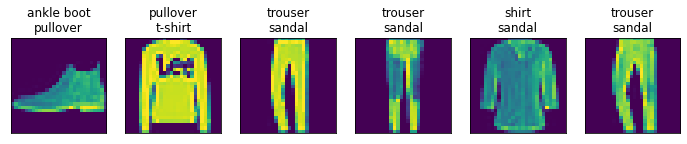

In [ ]:
#Prediction

def predict_ch3(net, test_iter, n=6):
  for X, y in test_iter:
    break
  trues = get_fashion_mnist_label(y)
  preds = get_fashion_mnist_label(net(X).argmax(axis=1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  show_images(
      X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n]
  )

predict_ch3(net, test_iter)

#Concise Implementation of Softmax Regression

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Initializaing Model Parameters

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [ ]:
#Softmax Implementation Revisited

loss = nn.CrossEntropyLoss()


In [ ]:
#Optimization Algorithm

trainer = torch.optim.SGD(net.parameters(), lr=0.1)